In [1]:
import dotenv
import os
dotenv.load_dotenv()
from comet_ml import API, APIExperiment
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import yaml

metrics_df

In [33]:
exp_dir = "../../experiments/bench-mnist/runs"
experiments = os.listdir(exp_dir)
full_df=[]
miss_metric = ["flops_test", "flops_train", "max_test_memory", "max_train_memory", "number_parameters"]
for exp in experiments:
    metrics = os.path.join(exp_dir, exp, "version_0", "metrics.csv")
    hparams_file = os.path.join(exp_dir, exp, "version_0", "hparams.yaml")
    if os.path.exists(metrics) and os.path.exists(hparams_file):
        with open(hparams_file, "r") as f:
            hparams = yaml.load(f, Loader=yaml.FullLoader)
        metrics_df = pd.read_csv(metrics)
        metrics_series = metrics_df.iloc[-1].copy()
        for key in miss_metric:
            if key in metrics_df:
                col= metrics_df[key].dropna()
                if len(col)>0:
                    metrics_series[key]=col.iloc[-1]
        for key, value in hparams["config"].items():
            metrics_series[key]=value
        full_df.append(metrics_series)
results_mnist = pd.DataFrame(full_df).dropna(subset="test_bpd")

In [31]:
exp_dir = "../../experiments/bench-cifar/runs"
experiments = os.listdir(exp_dir)
full_df=[]
miss_metric = ["flops_test", "flops_train", "max_test_memory", "max_train_memory", "number_parameters"]
for exp in experiments:
    metrics = os.path.join(exp_dir, exp, "version_0", "metrics.csv")
    hparams_file = os.path.join(exp_dir, exp, "version_0", "hparams.yaml")
    if os.path.exists(metrics) and os.path.exists(hparams_file):
        with open(hparams_file, "r") as f:
            hparams = yaml.load(f, Loader=yaml.FullLoader)
        metrics_df = pd.read_csv(metrics)
        metrics_series = metrics_df.iloc[-1].copy()
        for key in miss_metric:
            if key in metrics_df:
                col= metrics_df[key].dropna()
                if len(col)>0:
                    metrics_series[key]=col.iloc[-1]
        for key, value in hparams["config"].items():
            metrics_series[key]=value
        full_df.append(metrics_series)
results_cifar = pd.DataFrame(full_df).dropna(subset="test_bpd")

In [34]:
results = pd.concat([results_mnist, results_cifar])

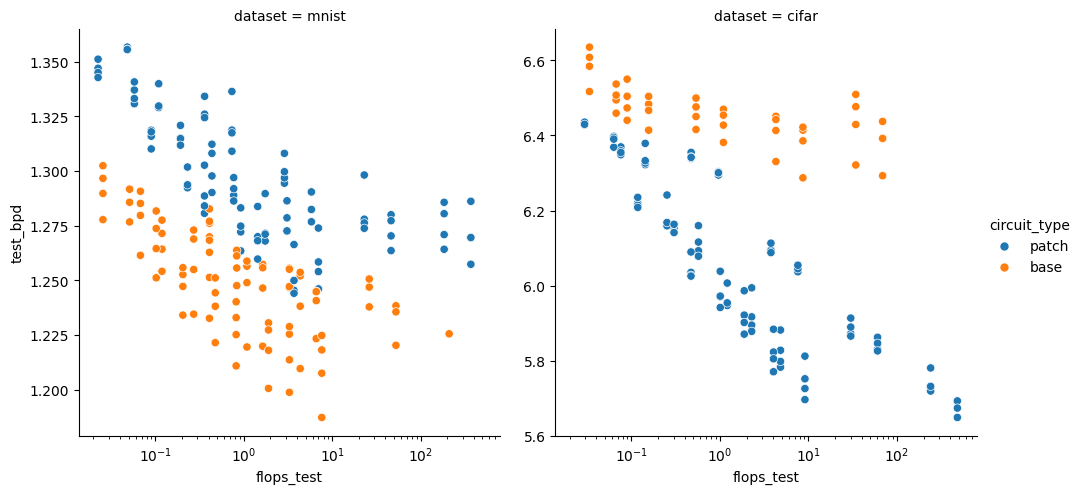

In [39]:
sb.relplot(results, x="flops_test", y="test_bpd", hue="circuit_type", col="dataset", facet_kws=dict(sharey=False))
plt.xscale('log')

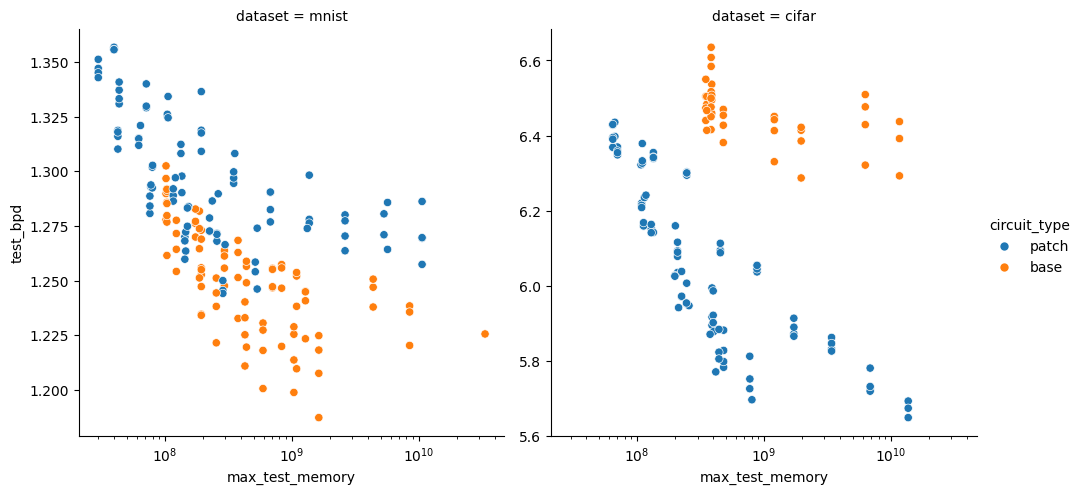

In [40]:

sb.relplot(results, x="max_test_memory", y="test_bpd", hue="circuit_type", col="dataset", facet_kws=dict(sharey=False))
plt.xscale('log')


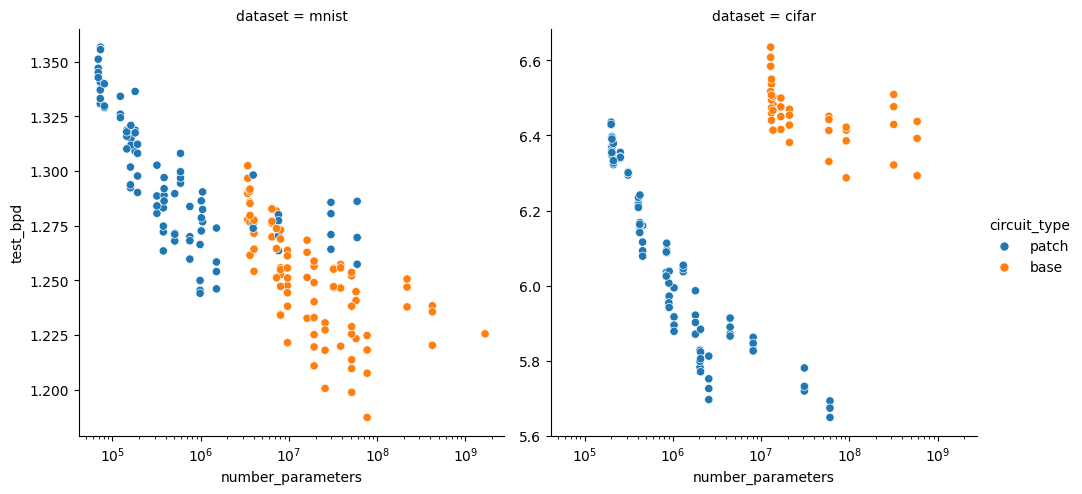

In [41]:

sb.relplot(results, x="number_parameters", y="test_bpd", hue="circuit_type", col="dataset", facet_kws=dict(sharey=False))
plt.xscale('log')


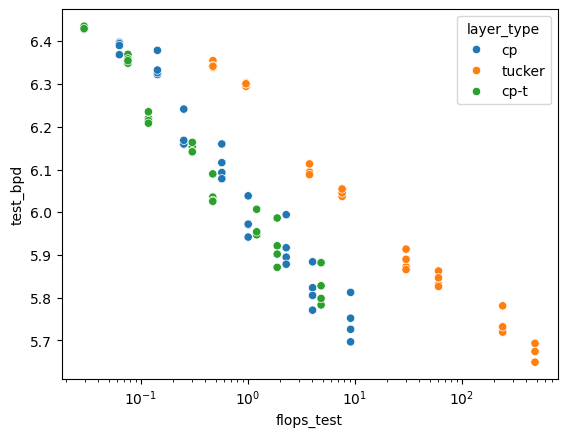

In [27]:
patch_only = results_cifar[results_cifar["circuit_type"]=="patch"]

sb.scatterplot(patch_only, x="flops_test", y="test_bpd", hue="layer_type")
plt.xscale('log')

In [49]:
best =results.sort_values('test_bpd', ascending=True).drop_duplicates(["dataset", "circuit_type"])
best[["circuit_type", "layer_type", "lr", "num_units", "region_graph", "dataset", "test_bpd"]]

,circuit_type,layer_type,lr,num_units,region_graph,dataset,test_bpd
33,base,cp,0.05,128,quad-graph,mnist,1.187285
228,patch,cp-t,0.05,128,quad-graph,mnist,1.244108
387,patch,tucker,0.05,128,quad-graph,cifar,5.649159
53,base,tucker,0.05,32,quad-graph,cifar,6.287167


epoch                float64
flops_test           float64
flops_train          float64
max_test_memory      float64
max_train_memory     float64
number_parameters    float64
step                 float64
test_bpd             float64
test_loss            float64
train_loss           float64
val_loss             float64
channel              float64
circuit_type          object
dataset               object
experiment_path       object
image_size            object
kernel_size           object
layer_type            object
lr                    object
num_units              int64
region_graph          object
dtype: object

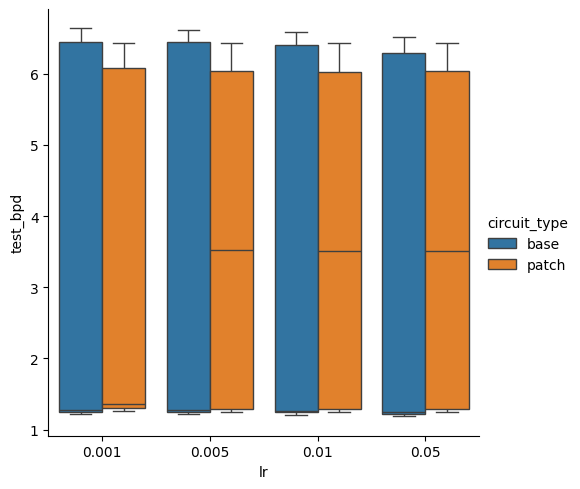

In [81]:
cat_lr = results.copy()
cat_lr["lr"] = cat_lr["lr"].astype(str)
sb.catplot(results, x="lr", y="test_bpd", hue="circuit_type", kind="box")
cat_lr.dtypes

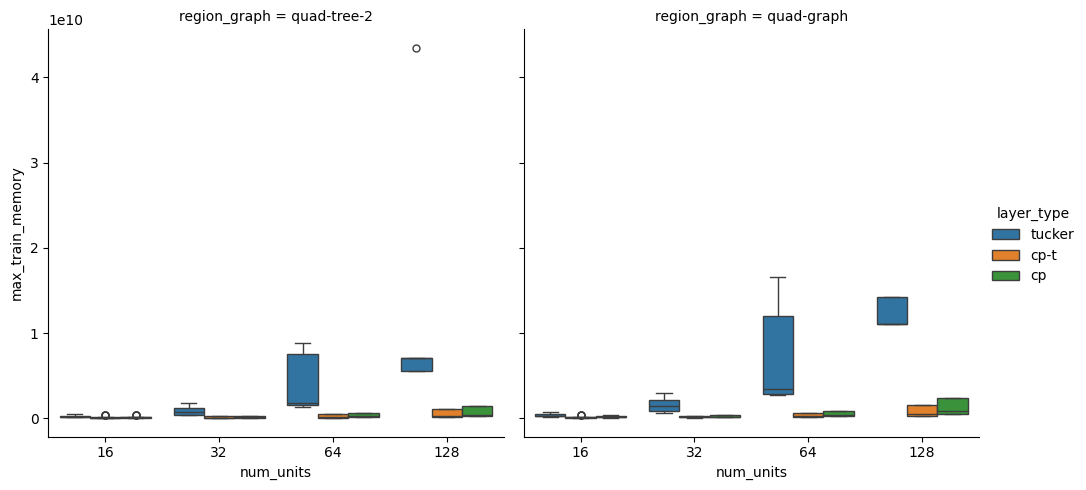

In [60]:
sb.catplot(results, y="max_train_memory", x="num_units", hue="layer_type", col="region_graph", kind="box")


In [ ]:
results.sort_values("max_train_memory", ascending=False)[["circuit_type", "layer_type", "lr", "num_units", "region_graph", "dataset", "test_bpd"]]

,circuit_type,layer_type,lr,num_units,region_graph,dataset,test_bpd
38,base,tucker,0.050,128,quad-tree-2,mnist,1.225559
80,base,tucker,0.005,64,quad-graph,cifar,6.437216
60,base,tucker,0.010,64,quad-graph,cifar,6.392047
33,base,tucker,0.050,64,quad-graph,cifar,6.292813
395,patch,tucker,0.005,128,quad-graph,cifar,5.693235
...,...,...,...,...,...,...,...
160,patch,cp,0.050,16,quad-tree-2,mnist,1.355613
246,patch,cp-t,0.001,16,quad-tree-2,mnist,1.351211
218,patch,cp-t,0.005,16,quad-tree-2,mnist,1.347059
169,patch,cp-t,0.010,16,quad-tree-2,mnist,1.342846


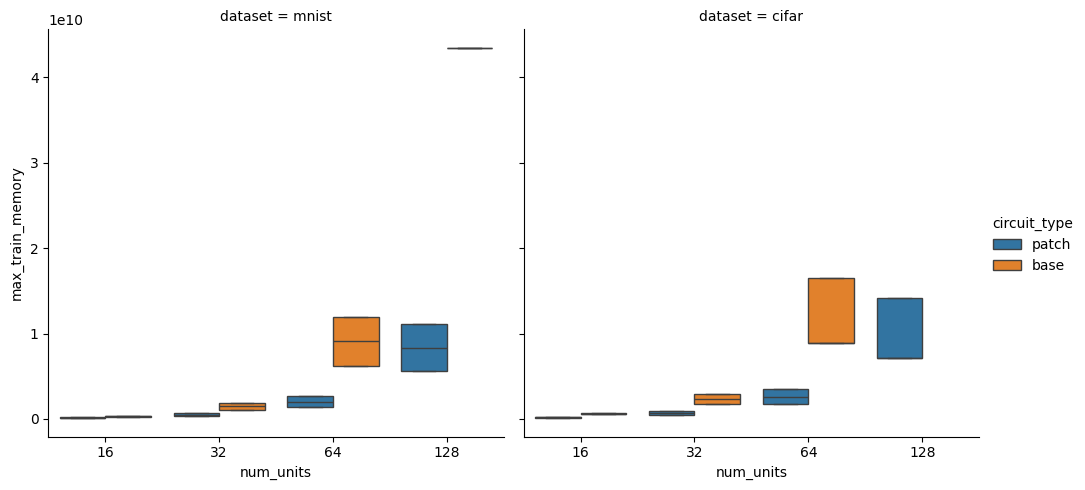

In [70]:
tucker=results[results["layer_type"]=="tucker"]
sb.catplot(tucker, y="max_train_memory", x="num_units", hue="circuit_type", col="dataset", kind="box")
